In [ ]:
# Export the strictly cleaned dataset
output_path_strict = 'bangkok_traffy_cleaned_strict.csv'
df_strict.to_csv(output_path_strict, index=False)

print(f"Strictly cleaned dataset saved to: {output_path_strict}")
print(f"Final shape: {df_strict.shape[0]:,} rows × {df_strict.shape[1]} columns")

# Final quality report
print("\n" + "="*60)
print("FINAL QUALITY REPORT - STRICT CLEANING")
print("="*60)
print(f"✅ Total records: {len(df_strict):,}")
print(f"✅ Missing values: 0")
print(f"✅ All rows complete and ready for ML")

# Verify again
final_missing = df_strict.isnull().sum().sum()
print(f"\nFinal verification - Total missing values: {final_missing}")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn pythainlp folium tqdm

In [6]:
# Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Thai NLP
from pythainlp import word_tokenize
from pythainlp.util import normalize as thai_normalize

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


In [8]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/[02] Academics/CEDT/dsde proj/bangkok_traffy.csv')
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
df.head()

Dataset Shape: 787,026 rows × 16 columns
Memory Usage: 1415.87 MB


,ticket_id,type,organization,comment,photo,photo_after,coords,address,subdistrict,district,province,timestamp,state,star,count_reopen,last_activity
0,2021-FYJTFP,{ความสะอาด},เขตบางซื่อ,ขยะเยอะ,https://storage.googleapis.com/traffy_public_bucket/attachment/2021-09/3063e748259afbb7171467e19...,NaN,"100.53084,13.81865",12/14 ถนน กรุงเทพ- นนทบุรี แขวง บางซื่อ เขตบางซื่อ กรุงเทพมหานคร 10800 ประเทศไทย,NaN,NaN,กรุงเทพมหานคร,2021-09-03 12:51:09.453003+00,เสร็จสิ้น,NaN,0,2022-06-04 15:34:14.609206+00
1,2021-CGPMUN,"{น้ำท่วม,ร้องเรียน}","เขตประเวศ,ฝ่ายโยธา เขตประเวศ",น้ำท่วมเวลาฝนตกและทะลุเข้าบ้านเดือดร้อนมากทุกๆปีจะมีเครื่องสูบน้ำแต่ปีนี้ไม่มีกทม.ปล่อยทิ้ง ชุมช...,https://storage.googleapis.com/traffy_public_bucket/attachment/2021-09/41ef2b1b465b708db17363a6d...,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-06/b562e36f971f02221bd0f32b7...,"100.66709,13.67891",189 เฉลิมพระเกียรติ ร.9 แขวง หนองบอน เขต ประเวศ กรุงเทพมหานคร 10250 ประเทศไทย,หนองบอน,ประเวศ,กรุงเทพมหานคร,2021-09-19 14:56:08.924992+00,เสร็จสิ้น,4.0,0,2022-06-21 08:21:09.532782+00
2,2021-7XATFA,{สะพาน},เขตสาทร,สะพานลอยปรับปรุงไม่เสร็จตามกำหนด\nปากซอย สาทร12,https://storage.googleapis.com/traffy_public_bucket/attachment/2021-09/b0b738c84fb0d0b0bfd5c5ac0...,NaN,"100.52649,13.72060",191/1 ถนน สาทรเหนือ แขวง สีลม เขตบางรัก กรุงเทพมหานคร 10500 ประเทศไทย,ยานนาวา,สาทร,กรุงเทพมหานคร,2021-09-26 05:03:52.594898+00,เสร็จสิ้น,NaN,0,2022-06-06 01:17:12.272904+00
3,2021-9U2NJT,{น้ำท่วม},"เขตบางซื่อ,ฝ่ายโยธา เขตบางซื่อ",น้ำท่วม,https://storage.googleapis.com/traffy_public_bucket/attachment/2021-10/5a36fa060eb2a750e3ff47cdd...,https://storage.googleapis.com/traffy_public_bucket/attachment/2022-09/7739f2143dfff32905f68fbf7...,"100.53099,13.81853",12/14 ถนน กรุงเทพ- นนทบุรี แขวง บางซื่อ เขตบางซื่อ กรุงเทพมหานคร 10800 ประเทศไทย,NaN,NaN,กรุงเทพมหานคร,2021-10-14 10:45:27.713884+00,เสร็จสิ้น,NaN,0,2022-09-08 08:35:43.784519+00
4,2021-DVEWYM,"{น้ำท่วม,ถนน}","เขตลาดพร้าว,ฝ่ายโยธา เขตลาดพร้าว",ซอยลาดพร้าววังหิน 75 ถนนลาดพร้าววังหิน แขวงลาดพร้าว เขตลาดพร้าว\n\n1. หลังจากฝนตกต่อเนื่องประมาณ...,https://storage.googleapis.com/traffy_public_bucket/attachment/2021-12/6b71a10f77a724a6151180eb5...,NaN,"100.59165,13.82280",702 ถ. ลาดพร้าววังหิน แขวงลาดพร้าว เขตลาดพร้าว กรุงเทพมหานคร 10230 ประเทศไทย,ลาดพร้าว,ลาดพร้าว,กรุงเทพมหานคร,2021-12-09 12:29:08.408763+00,เสร็จสิ้น,5.0,0,2022-08-12 07:18:44.884945+00


In [9]:
# Basic Data Overview
print("="*60)
print("DATA INFO")
print("="*60)
df.info()
print("\n" + "="*60)
print("NUMERICAL SUMMARY")
print("="*60)
df.describe()

DATA INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787026 entries, 0 to 787025
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ticket_id      778254 non-null  object 
 1   type           786929 non-null  object 
 2   organization   786455 non-null  object 
 3   comment        778254 non-null  object 
 4   photo          786911 non-null  object 
 5   photo_after    641309 non-null  object 
 6   coords         787026 non-null  object 
 7   address        778254 non-null  object 
 8   subdistrict    786460 non-null  object 
 9   district       786465 non-null  object 
 10  province       786831 non-null  object 
 11  timestamp      787026 non-null  object 
 12  state          787026 non-null  object 
 13  star           274097 non-null  float64
 14  count_reopen   787026 non-null  int64  
 15  last_activity  787026 non-null  object 
dtypes: float64(1), int64(1), object(14)
memory usage: 96.1+ MB

NUME

,star,count_reopen
count,274097.000000,787026.000000
mean,3.872801,0.123485
std,1.471863,0.823554
min,1.000000,0.000000
25%,3.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,100.000000


Missing Values Summary:
       Column  Missing Count  Missing %
         star         512929      65.17
  photo_after         145717      18.51
      address           8772       1.11
    ticket_id           8772       1.11
      comment           8772       1.11
 organization            571       0.07
  subdistrict            566       0.07
     district            561       0.07
     province            195       0.02
         type             97       0.01
        photo            115       0.01
       coords              0       0.00
    timestamp              0       0.00
        state              0       0.00
 count_reopen              0       0.00
last_activity              0       0.00


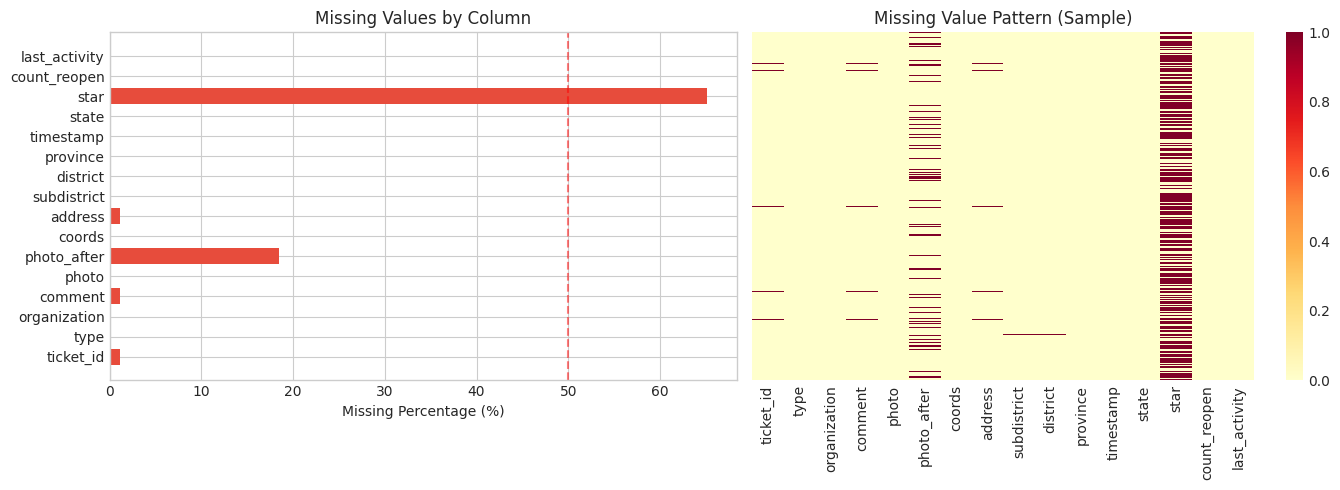

In [10]:
# Missing Values Analysis
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

print("Missing Values Summary:")
print(missing_df.to_string(index=False))

# Visualize missing values
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of missing percentages
colors = ['#e74c3c' if x > 0 else '#27ae60' for x in missing_pct.values]
axes[0].barh(missing.index, missing_pct.values, color=colors)
axes[0].set_xlabel('Missing Percentage (%)')
axes[0].set_title('Missing Values by Column')
axes[0].axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')

# Heatmap of missing pattern (sample for performance)
sample_df = df.sample(min(1000, len(df)), random_state=42)
sns.heatmap(sample_df.isnull(), cbar=True, yticklabels=False, ax=axes[1], cmap='YlOrRd')
axes[1].set_title('Missing Value Pattern (Sample)')

plt.tight_layout()
plt.show()

In [11]:
# Data Type Conversions
print("Converting data types...")

# Convert timestamps to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['last_activity'] = pd.to_datetime(df['last_activity'], errors='coerce')

# Parse coordinates into latitude and longitude
def parse_coords(coord_str):
    """Parse 'lon,lat' string into separate values"""
    if pd.isna(coord_str):
        return np.nan, np.nan
    try:
        parts = str(coord_str).split(',')
        if len(parts) == 2:
            lon, lat = float(parts[0]), float(parts[1])
            return lat, lon
    except:
        pass
    return np.nan, np.nan

coords_parsed = df['coords'].apply(parse_coords)
df['latitude'] = coords_parsed.apply(lambda x: x[0])
df['longitude'] = coords_parsed.apply(lambda x: x[1])

# Parse type column (remove braces)
def parse_type(type_str):
    """Parse '{cat1,cat2}' into list of categories"""
    if pd.isna(type_str):
        return []
    # Remove braces and split
    cleaned = str(type_str).strip('{}')
    return [t.strip() for t in cleaned.split(',') if t.strip()]

df['type_list'] = df['type'].apply(parse_type)
df['num_categories'] = df['type_list'].apply(len)

# Convert numeric columns
df['star'] = pd.to_numeric(df['star'], errors='coerce')
df['count_reopen'] = pd.to_numeric(df['count_reopen'], errors='coerce').fillna(0).astype(int)

print("Data types after conversion:")
print(df.dtypes)
print(f"\nNew columns added: latitude, longitude, type_list, num_categories")

Converting data types...
Data types after conversion:
ticket_id                      object
type                           object
organization                   object
comment                        object
photo                          object
photo_after                    object
coords                         object
address                        object
subdistrict                    object
district                       object
province                       object
timestamp         datetime64[ns, UTC]
state                          object
star                          float64
count_reopen                    int64
last_activity     datetime64[ns, UTC]
latitude                      float64
longitude                     float64
type_list                      object
num_categories                  int64
dtype: object

New columns added: latitude, longitude, type_list, num_categories


TEMPORAL ANALYSIS


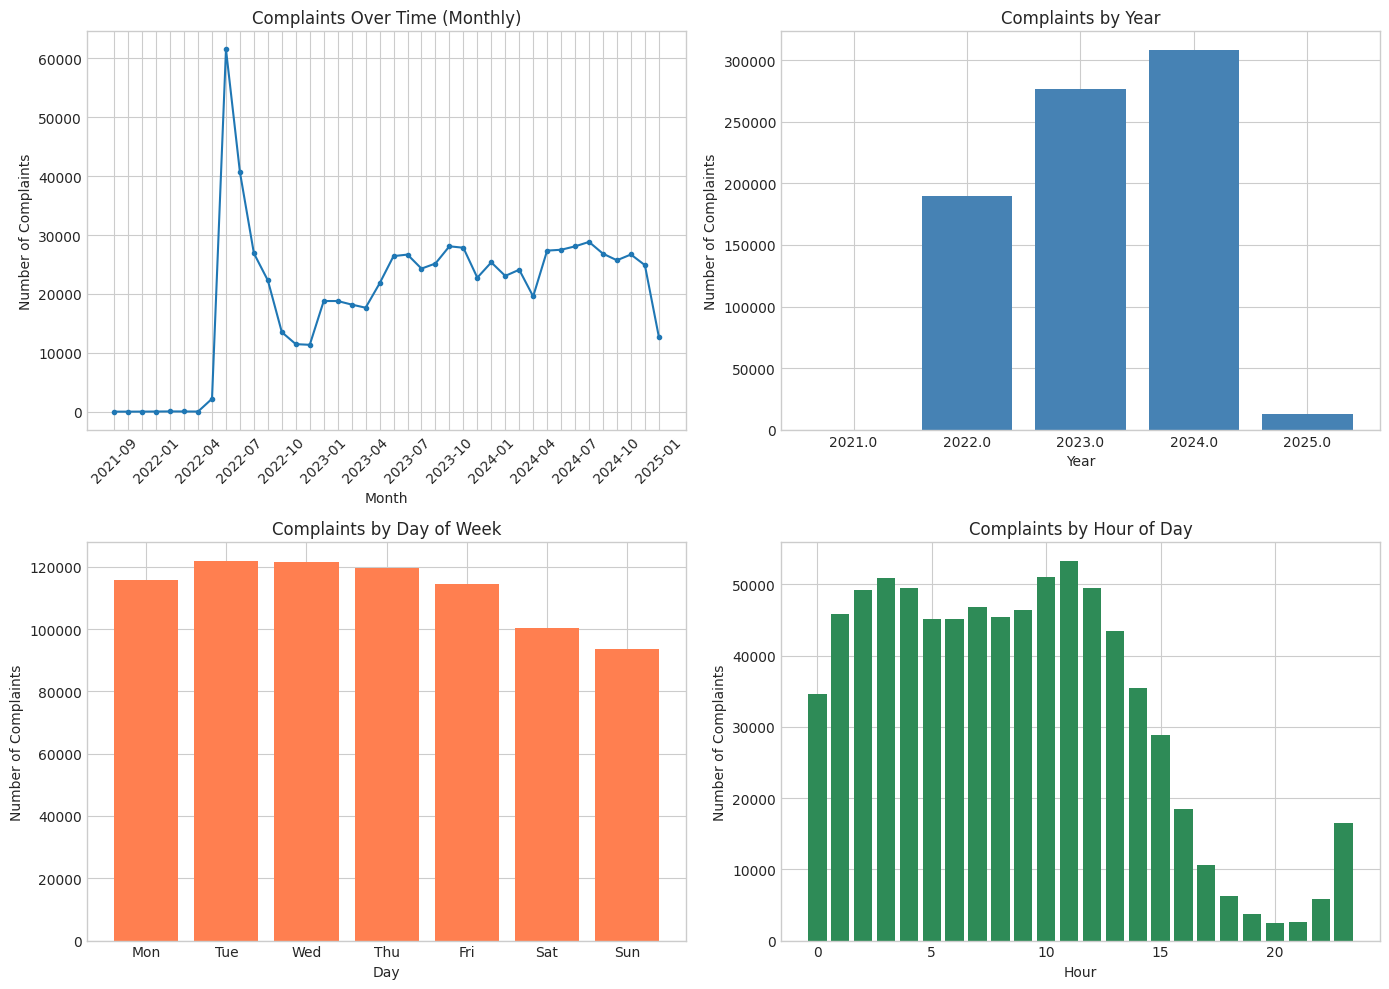

In [12]:
# EDA: Temporal Analysis
print("="*60)
print("TEMPORAL ANALYSIS")
print("="*60)

# Extract temporal features
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['hour'] = df['timestamp'].dt.hour

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Complaints over time (monthly)
monthly = df.groupby(df['timestamp'].dt.to_period('M')).size()
axes[0, 0].plot(monthly.index.astype(str), monthly.values, marker='o', markersize=3)
axes[0, 0].set_title('Complaints Over Time (Monthly)')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Complaints')
axes[0, 0].tick_params(axis='x', rotation=45)
# Show only every nth label for readability
n = max(1, len(monthly) // 12)
for i, label in enumerate(axes[0, 0].xaxis.get_ticklabels()):
    if i % n != 0:
        label.set_visible(False)

# Complaints by year
yearly = df['year'].value_counts().sort_index()
axes[0, 1].bar(yearly.index.astype(str), yearly.values, color='steelblue')
axes[0, 1].set_title('Complaints by Year')
axes[0, 1].set_xlabel('Year')
axes[0, 1].set_ylabel('Number of Complaints')

# Complaints by day of week
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_counts = df['day_of_week'].value_counts().sort_index()
axes[1, 0].bar(dow_names, dow_counts.values, color='coral')
axes[1, 0].set_title('Complaints by Day of Week')
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Number of Complaints')

# Complaints by hour
hourly = df['hour'].value_counts().sort_index()
axes[1, 1].bar(hourly.index, hourly.values, color='seagreen')
axes[1, 1].set_title('Complaints by Hour of Day')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Number of Complaints')

plt.tight_layout()
plt.show()

GEOGRAPHIC ANALYSIS
Valid coordinates: 787,026 (100.0%)


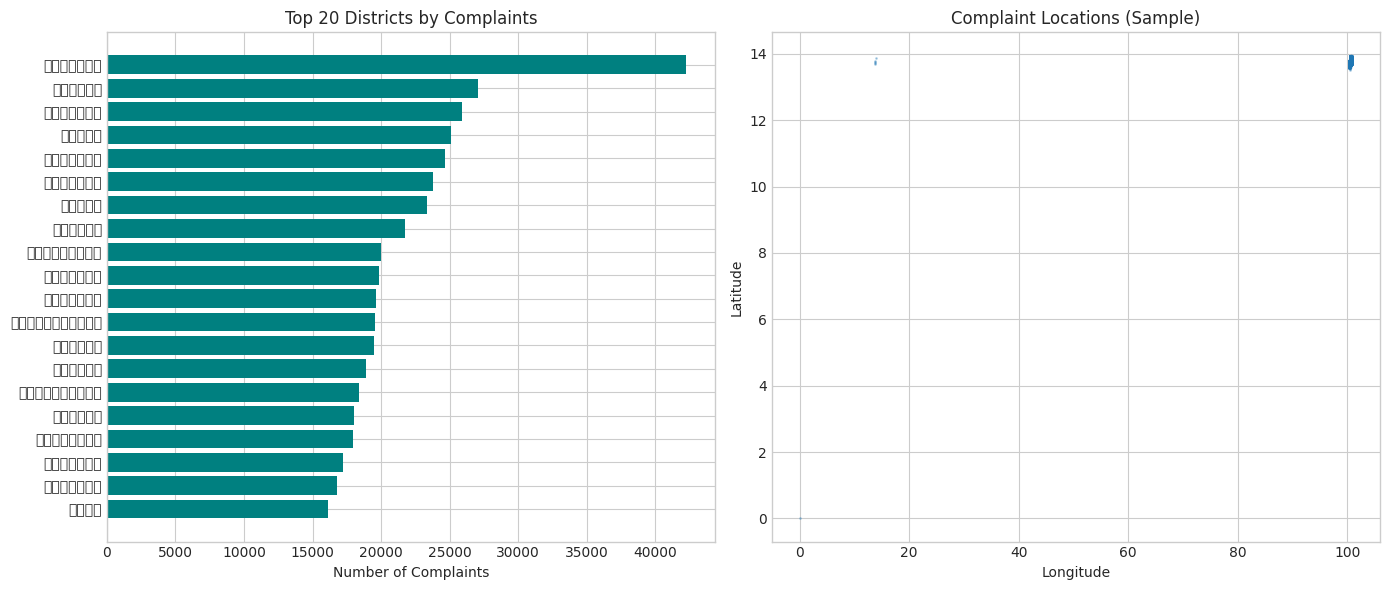


Interactive Map (Density):


In [13]:
# EDA: Geographic Analysis
print("="*60)
print("GEOGRAPHIC ANALYSIS")
print("="*60)

# Top districts by complaints
district_counts = df['district'].value_counts().head(20)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of top districts
axes[0].barh(district_counts.index[::-1], district_counts.values[::-1], color='teal')
axes[0].set_xlabel('Number of Complaints')
axes[0].set_title('Top 20 Districts by Complaints')

# Coordinate distribution
valid_coords = df[(df['latitude'].notna()) & (df['longitude'].notna())]
print(f"Valid coordinates: {len(valid_coords):,} ({len(valid_coords)/len(df)*100:.1f}%)")

# Scatter plot of coordinates (sample for performance)
sample_coords = valid_coords.sample(min(10000, len(valid_coords)), random_state=42)
axes[1].scatter(sample_coords['longitude'], sample_coords['latitude'], alpha=0.3, s=1)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Complaint Locations (Sample)')

plt.tight_layout()
plt.show()

# Interactive map with Plotly
print("\nInteractive Map (Density):")
fig_map = px.density_mapbox(
    sample_coords,
    lat='latitude',
    lon='longitude',
    radius=5,
    center=dict(lat=13.75, lon=100.5),
    zoom=10,
    mapbox_style='carto-positron',
    title='Bangkok Complaint Density Map'
)
fig_map.update_layout(height=500)
fig_map.show()

CATEGORY ANALYSIS


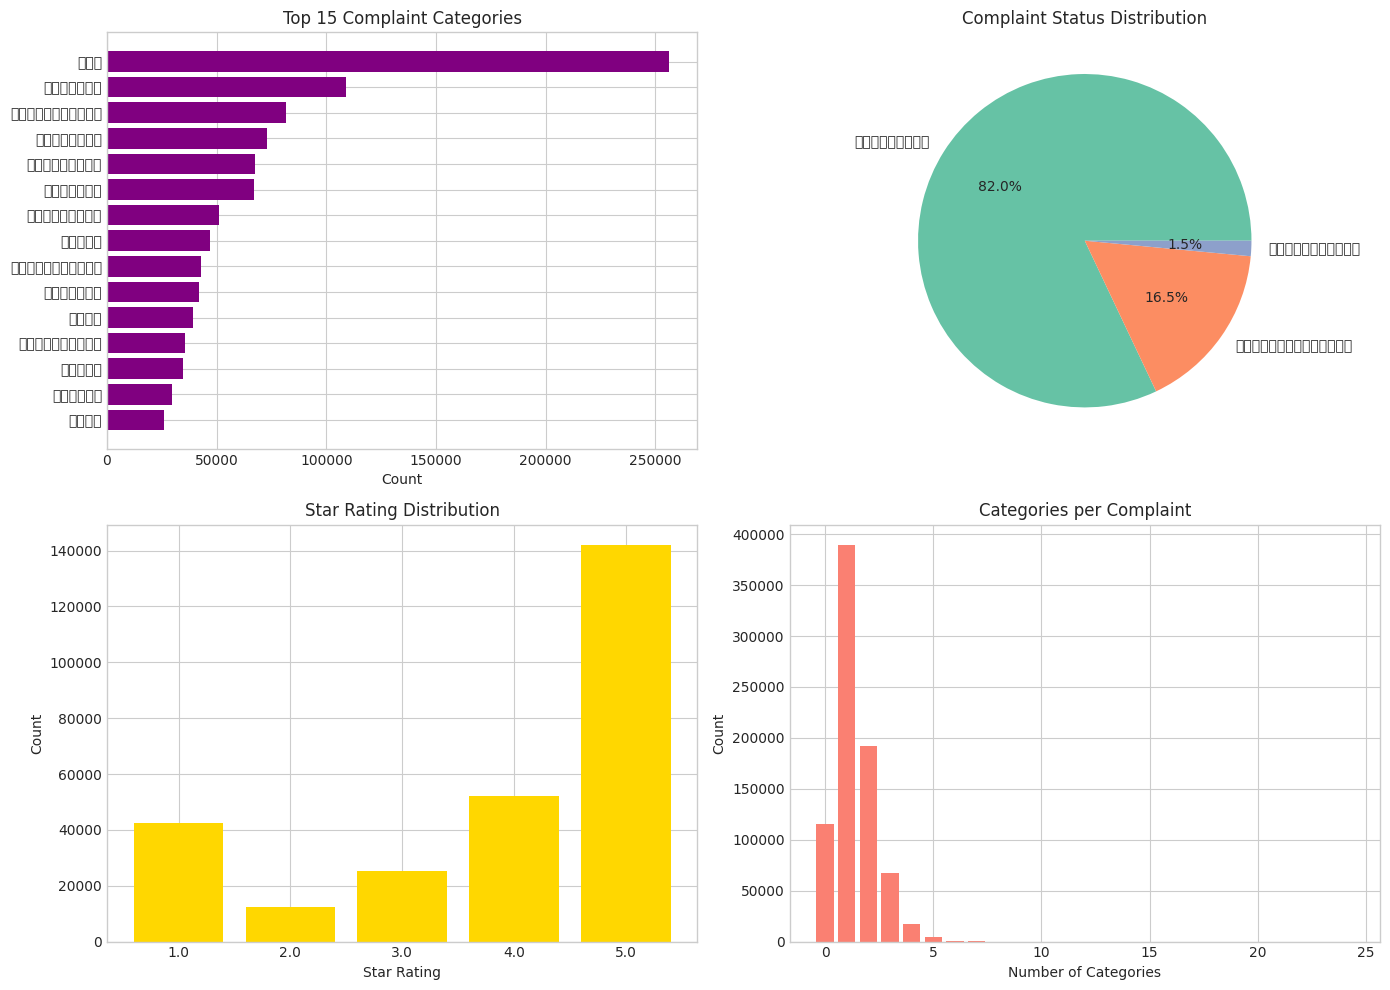


Top 10 Organizations by Workload:
organization
เขตปทุมวัน,ฝ่ายเทศกิจ เขตปทุมวัน                                                                5285
เขตหนองจอก                                                                                      4996
เขตจตุจักร,ฝ่ายเทศกิจ เขตจตุจักร                                                                4993
เขตสาทร,ฝ่ายเทศกิจ เขตสาทร                                                                      4367
เขตจตุจักร,ฝ่ายโยธา เขตจตุจักร                                                                  4207
เขตบางแค,ฝ่ายเทศกิจ เขตบางแค                                                                    4039
เขตพระนคร,ฝ่ายเทศกิจ เขตพระนคร                                                                  3761
เขตบางกอกน้อย,ฝ่ายเทศกิจ เขตบางกอกน้อย                                                          3750
เขตป้อมปราบศัตรูพ่าย,ฝ่ายเทศกิจ เขตป้อมปราบศัตรูพ่าย                                            3746
เขตประเวศ,ฝ่ายโยธา เขตประเวศ,ผอ.เขตประเวศ (

In [14]:
# EDA: Category Analysis
print("="*60)
print("CATEGORY ANALYSIS")
print("="*60)

# Flatten all categories
all_categories = [cat for cats in df['type_list'] for cat in cats]
category_counts = Counter(all_categories)
top_categories = pd.DataFrame(category_counts.most_common(15), columns=['Category', 'Count'])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top complaint types
axes[0, 0].barh(top_categories['Category'][::-1], top_categories['Count'][::-1], color='purple')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_title('Top 15 Complaint Categories')

# Status distribution
status_counts = df['state'].value_counts()
axes[0, 1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
               colors=sns.color_palette('Set2'))
axes[0, 1].set_title('Complaint Status Distribution')

# Star rating distribution
star_counts = df['star'].value_counts().sort_index()
axes[1, 0].bar(star_counts.index.astype(str), star_counts.values, color='gold')
axes[1, 0].set_xlabel('Star Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Star Rating Distribution')

# Number of categories per complaint
cat_per_complaint = df['num_categories'].value_counts().sort_index()
axes[1, 1].bar(cat_per_complaint.index, cat_per_complaint.values, color='salmon')
axes[1, 1].set_xlabel('Number of Categories')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Categories per Complaint')

plt.tight_layout()
plt.show()

# Top organizations
print("\nTop 10 Organizations by Workload:")
org_counts = df['organization'].value_counts().head(10)
print(org_counts.to_string())

TEXT ANALYSIS


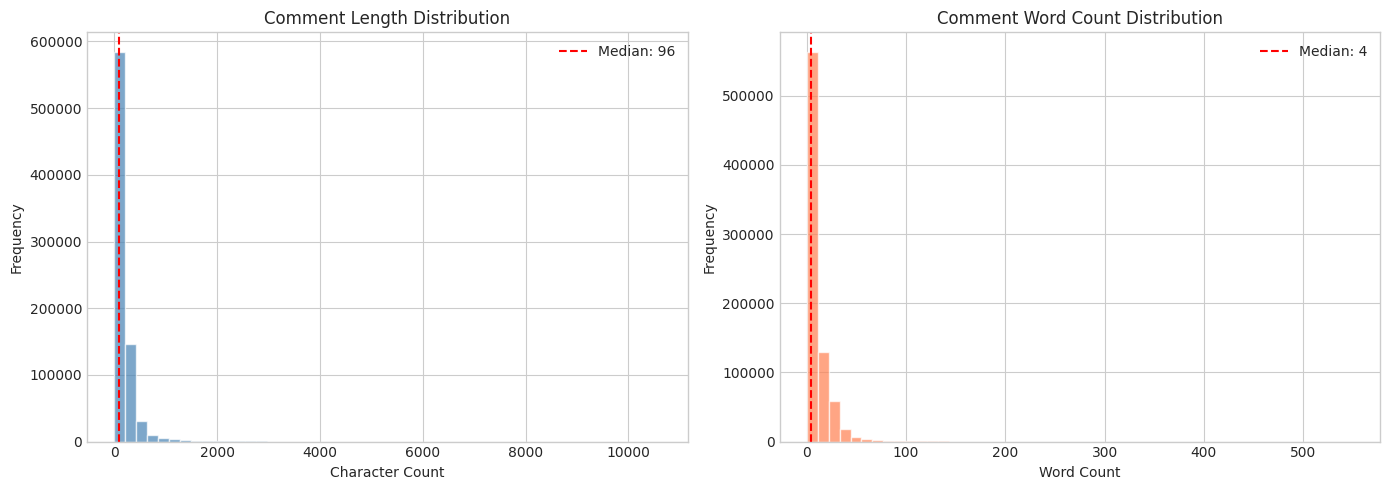


Analyzing Thai text (sample of 10,000 comments)...


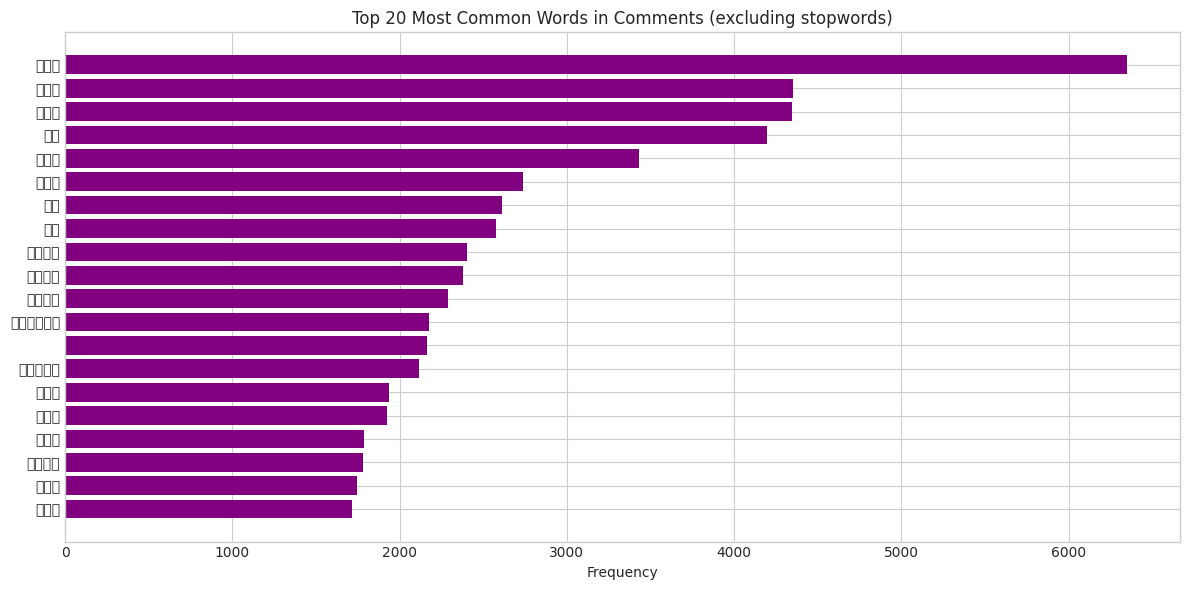


Total unique words: 13,407


In [15]:
# EDA: Text Analysis
print("="*60)
print("TEXT ANALYSIS")
print("="*60)

# Comment length analysis
df['comment_length'] = df['comment'].fillna('').apply(len)
df['comment_word_count'] = df['comment'].fillna('').apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Comment length distribution
axes[0].hist(df['comment_length'], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Comment Length Distribution')
axes[0].axvline(df['comment_length'].median(), color='red', linestyle='--', label=f'Median: {df["comment_length"].median():.0f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df['comment_word_count'], bins=50, color='coral', edgecolor='white', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Comment Word Count Distribution')
axes[1].axvline(df['comment_word_count'].median(), color='red', linestyle='--', label=f'Median: {df["comment_word_count"].median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Thai word frequency analysis (sample for performance)
print("\nAnalyzing Thai text (sample of 10,000 comments)...")
sample_comments = df['comment'].dropna().sample(min(10000, len(df['comment'].dropna())), random_state=42)

# Tokenize and count words
all_words = []
for comment in sample_comments:
    try:
        tokens = word_tokenize(str(comment), engine='newmm')
        # Filter out short tokens and common stopwords
        tokens = [t for t in tokens if len(t) > 1 and t not in [' ', '\n', '\t', 'ๆ', 'ที่', 'และ', 'ของ', 'ใน', 'มี', 'เป็น', 'ได้', 'จะ', 'ให้', 'กับ']]
        all_words.extend(tokens)
    except:
        pass

word_freq = Counter(all_words)
top_words = pd.DataFrame(word_freq.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 6))
plt.barh(top_words['Word'][::-1], top_words['Count'][::-1], color='purple')
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Words in Comments (excluding stopwords)')
plt.tight_layout()
plt.show()

print(f"\nTotal unique words: {len(word_freq):,}")

CORRELATION ANALYSIS


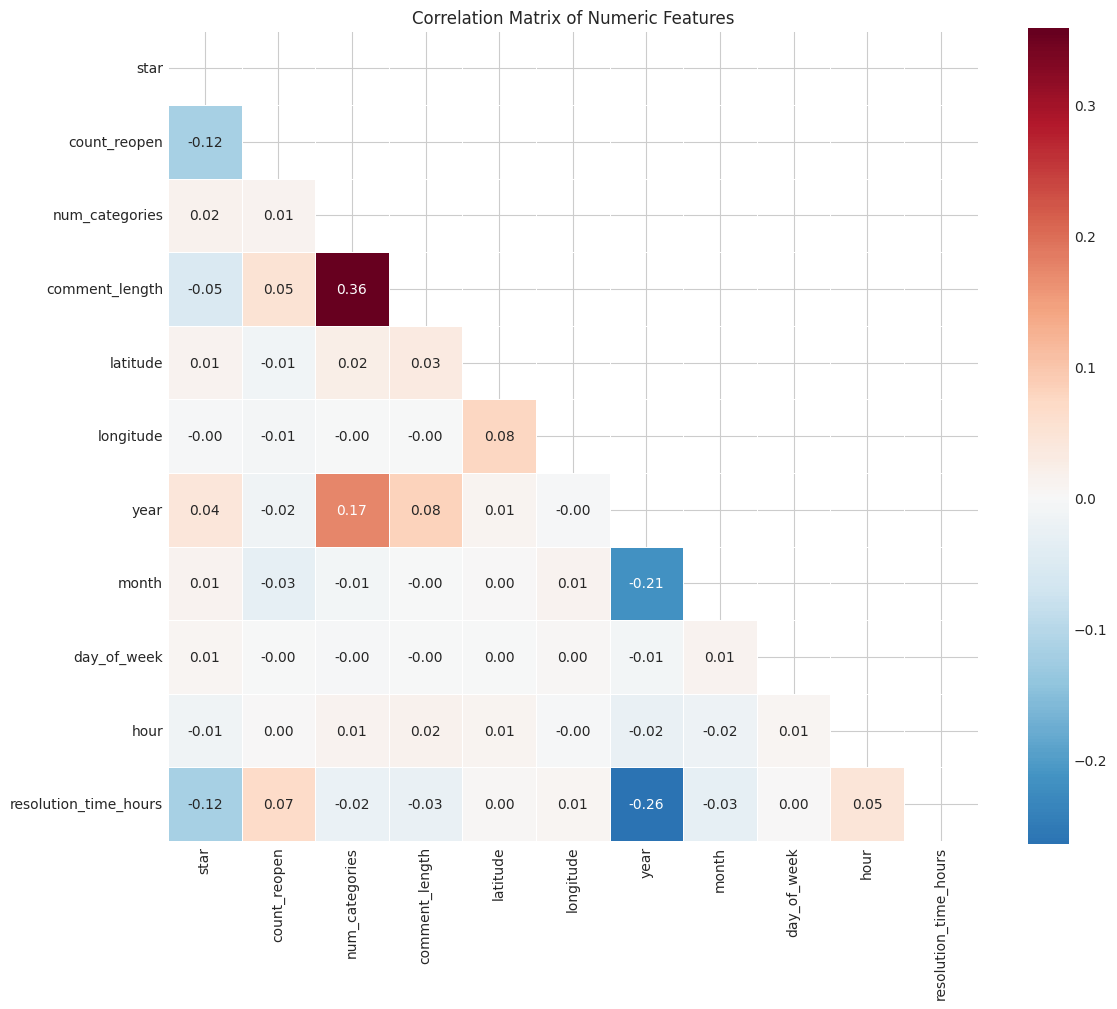


Resolution Time by Status:
                   mean  median   count
state                                  
กำลังดำเนินการ  2258.02  319.39  129620
รอรับเรื่อง      388.77    4.23   11706
เสร็จสิ้น       1718.76  206.21  645698

Mean Resolution Time by Category (Top 10 categories):
type_list
แสงสว่าง       3368.99
ป้ายจราจร      2932.10
สะพาน          2547.91
สายไฟ          2028.17
ความปลอดภัย    1997.40
ถนน            1806.94
จราจร          1788.18
ทางเท้า        1786.79
การเดินทาง     1741.99
สัตว์จรจัด     1695.38
Name: resolution_time_hours, dtype: float64


In [16]:
# EDA: Correlation Analysis
print("="*60)
print("CORRELATION ANALYSIS")
print("="*60)

# Calculate resolution time
df['resolution_time_hours'] = (df['last_activity'] - df['timestamp']).dt.total_seconds() / 3600

# Select numeric columns for correlation
numeric_cols = ['star', 'count_reopen', 'num_categories', 'comment_length',
                'latitude', 'longitude', 'year', 'month', 'day_of_week', 'hour',
                'resolution_time_hours']
numeric_df = df[numeric_cols].dropna()

# Correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

# Resolution time by status
print("\nResolution Time by Status:")
resolution_by_status = df.groupby('state')['resolution_time_hours'].agg(['mean', 'median', 'count'])
print(resolution_by_status.round(2))

# Resolution time by category (top 10)
print("\nMean Resolution Time by Category (Top 10 categories):")
# Explode type_list to get resolution time per category
df_exploded = df.explode('type_list')
resolution_by_cat = df_exploded.groupby('type_list')['resolution_time_hours'].mean().sort_values(ascending=False).head(10)
print(resolution_by_cat.round(2))

In [17]:
# DATA CLEANING: Handle Missing Values
print("="*60)
print("DATA CLEANING: MISSING VALUES")
print("="*60)

# Store original shape
original_shape = df.shape
print(f"Original dataset shape: {original_shape}")

# Create a copy for cleaning
df_clean = df.copy()

# 1. Handle photo columns - create binary flags
df_clean['has_photo'] = df_clean['photo'].notna().astype(int)
df_clean['has_photo_after'] = df_clean['photo_after'].notna().astype(int)

# 2. Handle comment - fill with empty string
df_clean['comment'] = df_clean['comment'].fillna('')

# 3. Handle coordinates - keep rows with valid coords for geo analysis
# Flag rows with missing coordinates instead of dropping
df_clean['has_valid_coords'] = (df_clean['latitude'].notna() & df_clean['longitude'].notna()).astype(int)

# 4. Handle star rating - fill with 0 (unknown/not rated)
df_clean['star'] = df_clean['star'].fillna(0).astype(int)

# 5. Handle address fields - fill with 'Unknown'
df_clean['address'] = df_clean['address'].fillna('Unknown')
df_clean['subdistrict'] = df_clean['subdistrict'].fillna('Unknown')
df_clean['district'] = df_clean['district'].fillna('Unknown')

# 6. Handle organization - fill with 'Unknown'
df_clean['organization'] = df_clean['organization'].fillna('Unknown')

# Report cleaning results
print("\nMissing values after cleaning:")
missing_after = df_clean.isnull().sum()
print(missing_after[missing_after > 0] if missing_after.sum() > 0 else "No missing values!")

print(f"\nNew binary features created: has_photo, has_photo_after, has_valid_coords")

DATA CLEANING: MISSING VALUES
Original dataset shape: (787026, 27)

Missing values after cleaning:
ticket_id                  8772
type                         97
photo                       115
photo_after              145717
province                    195
timestamp                     1
last_activity                 2
year                          1
month                         1
day_of_week                   1
hour                          1
resolution_time_hours         2
dtype: int64

New binary features created: has_photo, has_photo_after, has_valid_coords


DATA CLEANING: COORDINATES
Total rows with coordinates: 787,026
Coordinates within Bangkok bounds: 785,947 (99.9%)
Coordinate outliers (outside Bangkok): 1,079 (0.1%)


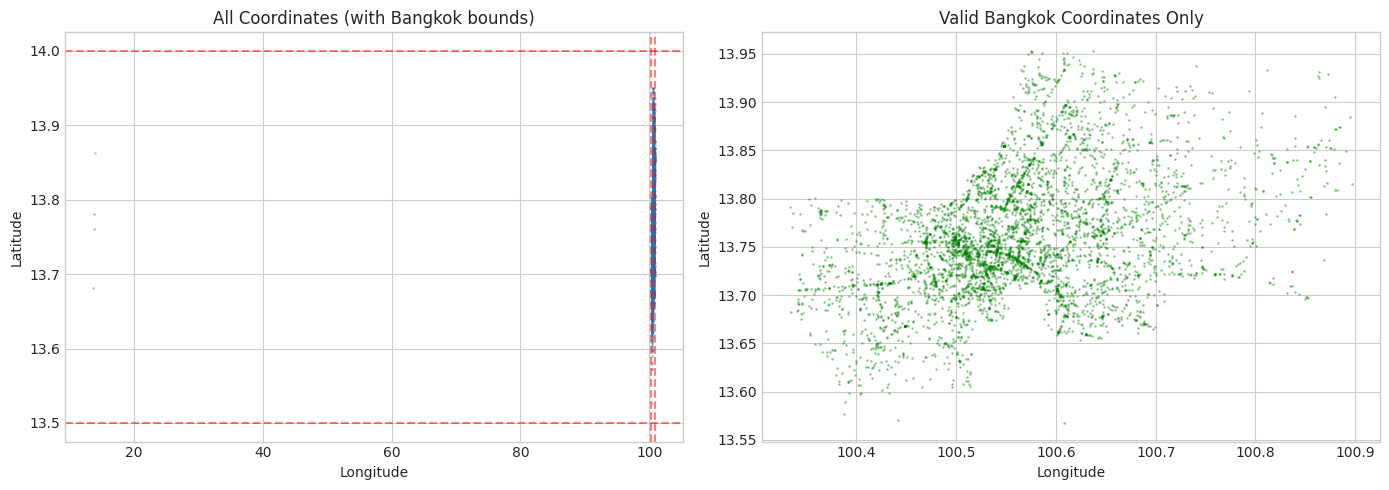

In [18]:
# DATA CLEANING: Clean Coordinates
print("="*60)
print("DATA CLEANING: COORDINATES")
print("="*60)

# Bangkok bounding box (approximate)
BANGKOK_LAT_MIN, BANGKOK_LAT_MAX = 13.5, 14.0
BANGKOK_LON_MIN, BANGKOK_LON_MAX = 100.3, 100.9

# Check coordinate validity
valid_mask = (
    (df_clean['latitude'] >= BANGKOK_LAT_MIN) &
    (df_clean['latitude'] <= BANGKOK_LAT_MAX) &
    (df_clean['longitude'] >= BANGKOK_LON_MIN) &
    (df_clean['longitude'] <= BANGKOK_LON_MAX)
)

# Create validity flag
df_clean['coords_in_bangkok'] = valid_mask.astype(int)

# Report
total_with_coords = df_clean['has_valid_coords'].sum()
valid_bangkok = valid_mask.sum()
outliers = total_with_coords - valid_bangkok

print(f"Total rows with coordinates: {total_with_coords:,}")
print(f"Coordinates within Bangkok bounds: {valid_bangkok:,} ({valid_bangkok/total_with_coords*100:.1f}%)")
print(f"Coordinate outliers (outside Bangkok): {outliers:,} ({outliers/total_with_coords*100:.1f}%)")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before - all coordinates
sample_all = df_clean[df_clean['has_valid_coords'] == 1].sample(min(5000, valid_bangkok), random_state=42)
axes[0].scatter(sample_all['longitude'], sample_all['latitude'], alpha=0.3, s=1)
axes[0].axhline(y=BANGKOK_LAT_MIN, color='red', linestyle='--', alpha=0.5)
axes[0].axhline(y=BANGKOK_LAT_MAX, color='red', linestyle='--', alpha=0.5)
axes[0].axvline(x=BANGKOK_LON_MIN, color='red', linestyle='--', alpha=0.5)
axes[0].axvline(x=BANGKOK_LON_MAX, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('All Coordinates (with Bangkok bounds)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# After - only valid Bangkok coordinates
sample_valid = df_clean[df_clean['coords_in_bangkok'] == 1].sample(min(5000, valid_bangkok), random_state=42)
axes[1].scatter(sample_valid['longitude'], sample_valid['latitude'], alpha=0.3, s=1, color='green')
axes[1].set_title('Valid Bangkok Coordinates Only')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()

In [19]:
# DATA CLEANING: Clean Thai Text
print("="*60)
print("DATA CLEANING: THAI TEXT")
print("="*60)

def clean_thai_text(text):
    """Clean and normalize Thai text"""
    if pd.isna(text) or text == '':
        return ''

    text = str(text)

    # Normalize Thai text using pythainlp
    text = thai_normalize(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text cleaning to comments (sample first to test, then full)
print("Cleaning comment text...")
df_clean['comment_cleaned'] = df_clean['comment'].apply(clean_thai_text)

# Clean the primary category (first category in the list)
df_clean['primary_category'] = df_clean['type_list'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

# Report
print(f"Comment cleaning complete!")
print(f"\nSample cleaned comments:")
sample = df_clean[df_clean['comment_cleaned'] != ''].sample(3, random_state=42)
for idx, row in sample.iterrows():
    print(f"  Original: {row['comment'][:100]}...")
    print(f"  Cleaned:  {row['comment_cleaned'][:100]}...")
    print()

DATA CLEANING: THAI TEXT
Cleaning comment text...
Comment cleaning complete!

Sample cleaned comments:
  Original: ตั้งขายของล้ำลงมากีดขวางทางเท้า...
  Cleaned:  ตั้งขายของล้ำลงมากีดขวางทางเท้า...

  Original: เสียงดังรบกวน...
  Cleaned:  เสียงดังรบกวน...

  Original: ผมถ่ายหลักฐานให้ดูเขาขาย 8 โมงเกือบทุกวันกับถึง 9:00 น หน้าเซ็นทรัลเวิลด์เวลาก็บอกวันนี้วันที่ 28 วั...
  Cleaned:  ผมถ่ายหลักฐานให้ดูเขาขาย 8 โมงเกือบทุกวันกับถึง 9:00 น หน้าเซ็นทรัลเวิลด์เวลาก็บอกวันนี้วันที่ 28 วั...



In [20]:
# DATA CLEANING: Clean Categories & State
print("="*60)
print("DATA CLEANING: CATEGORIES & STATE")
print("="*60)

# Standardize state values
state_mapping = {
    'เสร็จสิ้น': 'completed',
    'กำลังดำเนินการ': 'in_progress',
    'รอรับเรื่อง': 'pending'
}
df_clean['state_en'] = df_clean['state'].map(state_mapping).fillna('other')

# Create is_resolved binary flag
df_clean['is_resolved'] = (df_clean['state_en'] == 'completed').astype(int)

# Report category cleaning
print("State value standardization:")
print(df_clean['state_en'].value_counts())

print("\n\nTop 10 Primary Categories:")
print(df_clean['primary_category'].value_counts().head(10))

DATA CLEANING: CATEGORIES & STATE
State value standardization:
state_en
completed      645700
in_progress    129620
pending         11706
Name: count, dtype: int64


Top 10 Primary Categories:
primary_category
ถนน            164500
Unknown        115207
ทางเท้า         75246
แสงสว่าง        51292
ความสะอาด       45609
กีดขวาง         45052
ความปลอดภัย     40502
ท่อระบายน้ำ     31010
จราจร           28846
น้ำท่วม         24527
Name: count, dtype: int64


In [21]:
# FEATURE ENGINEERING: Create ML-Ready Features
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# 1. Time-based features (already created: year, month, day_of_week, hour)
df_clean['is_weekend'] = (df_clean['day_of_week'] >= 5).astype(int)
df_clean['is_business_hours'] = ((df_clean['hour'] >= 8) & (df_clean['hour'] <= 17)).astype(int)

# 2. Resolution time features
df_clean['resolution_time_days'] = df_clean['resolution_time_hours'] / 24
df_clean['quick_resolution'] = (df_clean['resolution_time_hours'] <= 24).astype(int)  # resolved within 24h

# 3. Text features
df_clean['has_comment'] = (df_clean['comment_length'] > 0).astype(int)
df_clean['long_comment'] = (df_clean['comment_length'] > df_clean['comment_length'].median()).astype(int)

# 4. Engagement features
df_clean['was_reopened'] = (df_clean['count_reopen'] > 0).astype(int)
df_clean['high_star'] = (df_clean['star'] >= 4).astype(int)

# Summary of new features
new_features = [
    'has_photo', 'has_photo_after', 'has_valid_coords', 'coords_in_bangkok',
    'is_weekend', 'is_business_hours', 'resolution_time_days', 'quick_resolution',
    'has_comment', 'long_comment', 'was_reopened', 'high_star',
    'is_resolved', 'primary_category', 'state_en', 'comment_cleaned'
]

print(f"New features created for ML: {len(new_features)}")
for feat in new_features:
    if feat in df_clean.columns:
        if df_clean[feat].dtype in ['int64', 'float64', 'int32', 'float32']:
            print(f"  - {feat}: {df_clean[feat].dtype} (mean: {df_clean[feat].mean():.3f})")
        else:
            print(f"  - {feat}: {df_clean[feat].dtype} ({df_clean[feat].nunique()} unique values)")

FEATURE ENGINEERING
New features created for ML: 16
  - has_photo: int64 (mean: 1.000)
  - has_photo_after: int64 (mean: 0.815)
  - has_valid_coords: int64 (mean: 1.000)
  - coords_in_bangkok: int64 (mean: 0.999)
  - is_weekend: int64 (mean: 0.246)
  - is_business_hours: int64 (mean: 0.486)
  - resolution_time_days: float64 (mean: 74.491)
  - quick_resolution: int64 (mean: 0.186)
  - has_comment: int64 (mean: 0.989)
  - long_comment: int64 (mean: 0.498)
  - was_reopened: int64 (mean: 0.067)
  - high_star: int64 (mean: 0.247)
  - is_resolved: int64 (mean: 0.820)
  - primary_category: object (25 unique values)
  - state_en: object (3 unique values)
  - comment_cleaned: object (682991 unique values)


In [22]:
# EXPORT: Save Cleaned Dataset
print("="*60)
print("EXPORTING CLEANED DATASET")
print("="*60)

# Select columns for export (drop intermediate/redundant columns)
columns_to_drop = ['photo', 'photo_after', 'coords', 'type', 'comment']  # Keep cleaned versions
df_export = df_clean.drop(columns=columns_to_drop, errors='ignore')

# Also need to handle the type_list column (can't save list to CSV directly)
df_export['categories'] = df_export['type_list'].apply(lambda x: '|'.join(x) if isinstance(x, list) else '')
df_export = df_export.drop(columns=['type_list'], errors='ignore')

# Save to CSV
output_path = 'bangkok_traffy_cleaned.csv'
df_export.to_csv(output_path, index=False)

print(f"Cleaned dataset saved to: {output_path}")
print(f"Shape: {df_export.shape[0]:,} rows × {df_export.shape[1]} columns")
print(f"File size: {df_export.memory_usage(deep=True).sum() / 1024**2:.2f} MB (in memory)")

# Show final columns
print(f"\nFinal columns ({len(df_export.columns)}):")
for i, col in enumerate(df_export.columns, 1):
    print(f"  {i:2}. {col}")

EXPORTING CLEANED DATASET
Cleaned dataset saved to: bangkok_traffy_cleaned.csv
Shape: 787,026 rows × 38 columns
File size: 1678.76 MB (in memory)

Final columns (38):
   1. ticket_id
   2. organization
   3. address
   4. subdistrict
   5. district
   6. province
   7. timestamp
   8. state
   9. star
  10. count_reopen
  11. last_activity
  12. latitude
  13. longitude
  14. num_categories
  15. year
  16. month
  17. day_of_week
  18. hour
  19. comment_length
  20. comment_word_count
  21. resolution_time_hours
  22. has_photo
  23. has_photo_after
  24. has_valid_coords
  25. coords_in_bangkok
  26. comment_cleaned
  27. primary_category
  28. state_en
  29. is_resolved
  30. is_weekend
  31. is_business_hours
  32. resolution_time_days
  33. quick_resolution
  34. has_comment
  35. long_comment
  36. was_reopened
  37. high_star
  38. categories


In [23]:
# DATA QUALITY REPORT
print("="*60)
print("DATA QUALITY REPORT - READY FOR ML")
print("="*60)

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(f"Total records: {len(df_export):,}")
print(f"Total features: {len(df_export.columns)}")
print(f"Date range: {df_export['timestamp'].min()} to {df_export['timestamp'].max()}")

print("\n" + "="*60)
print("MISSING VALUES (Final)")
print("="*60)
final_missing = df_export.isnull().sum()
if final_missing.sum() > 0:
    print(final_missing[final_missing > 0])
else:
    print("No missing values in the cleaned dataset!")

print("\n" + "="*60)
print("FEATURE TYPES")
print("="*60)
print(f"Numeric features: {len(df_export.select_dtypes(include=[np.number]).columns)}")
print(f"Categorical features: {len(df_export.select_dtypes(include=['object']).columns)}")
print(f"Datetime features: {len(df_export.select_dtypes(include=['datetime64']).columns)}")

print("\n" + "="*60)
print("ML-READY FEATURES")
print("="*60)
binary_features = ['has_photo', 'has_photo_after', 'has_valid_coords', 'coords_in_bangkok',
                   'is_weekend', 'is_business_hours', 'quick_resolution', 'has_comment',
                   'long_comment', 'was_reopened', 'high_star', 'is_resolved']
numeric_features = ['star', 'count_reopen', 'num_categories', 'comment_length',
                    'latitude', 'longitude', 'year', 'month', 'day_of_week', 'hour',
                    'resolution_time_hours', 'resolution_time_days', 'comment_word_count']
categorical_features = ['district', 'subdistrict', 'organization', 'state_en', 'primary_category']

print(f"\nBinary features ({len(binary_features)}): {', '.join(binary_features)}")
print(f"\nNumeric features ({len(numeric_features)}): {', '.join(numeric_features)}")
print(f"\nCategorical features ({len(categorical_features)}): {', '.join(categorical_features)}")

print("\n" + "="*60)
print("READY FOR ML CHECKLIST")
print("="*60)
checklist = [
    ("Missing values handled", final_missing.sum() == 0),
    ("Timestamps converted to datetime", df_export['timestamp'].dtype == 'datetime64[ns]'),
    ("Coordinates parsed and validated", 'latitude' in df_export.columns and 'coords_in_bangkok' in df_export.columns),
    ("Thai text normalized", 'comment_cleaned' in df_export.columns),
    ("Categories parsed", 'primary_category' in df_export.columns),
    ("Binary features created", all(f in df_export.columns for f in binary_features)),
    ("Resolution time calculated", 'resolution_time_hours' in df_export.columns),
    ("State standardized to English", 'state_en' in df_export.columns)
]

for item, passed in checklist:
    status = "PASS" if passed else "FAIL"
    print(f"  [{status}] {item}")

print("\n" + "="*60)
print("PREPROCESSING COMPLETE!")
print("="*60)
print(f"\nCleaned dataset saved as: bangkok_traffy_cleaned.csv")
print("Ready for machine learning modeling!")

DATA QUALITY REPORT - READY FOR ML

DATASET SUMMARY
Total records: 787,026
Total features: 38
Date range: 2021-09-03 12:51:09.453003+00:00 to 2025-01-16 02:53:34.290375+00:00

MISSING VALUES (Final)
ticket_id                8772
province                  195
timestamp                   1
last_activity               2
year                        1
month                       1
day_of_week                 1
hour                        1
resolution_time_hours       2
resolution_time_days        2
dtype: int64

FEATURE TYPES
Numeric features: 25
Categorical features: 11
Datetime features: 0

ML-READY FEATURES

Binary features (12): has_photo, has_photo_after, has_valid_coords, coords_in_bangkok, is_weekend, is_business_hours, quick_resolution, has_comment, long_comment, was_reopened, high_star, is_resolved

Numeric features (13): star, count_reopen, num_categories, comment_length, latitude, longitude, year, month, day_of_week, hour, resolution_time_hours, resolution_time_days, comment_word

In [ ]:
# STRICT CLEANING: Drop all rows with ANY missing values
print("="*60)
print("STRICT CLEANING: REMOVING ALL INCOMPLETE ROWS")
print("="*60)

# Check current missing values
print(f"Before cleaning: {len(df_export):,} rows")
missing_before = df_export.isnull().sum()
print(f"Columns with missing values:")
print(missing_before[missing_before > 0])

# Drop all rows with any missing value
df_strict = df_export.dropna()

print(f"\nAfter cleaning: {len(df_strict):,} rows")
print(f"Rows removed: {len(df_export) - len(df_strict):,} ({(len(df_export) - len(df_strict))/len(df_export)*100:.2f}%)")

# Verify no missing values
assert df_strict.isnull().sum().sum() == 0, "Still has missing values!"
print("\n✅ No missing values remain!")